#ENV

In [ ]:
# !wget https://s3.amazonaws.com/conceptnet/downloads/2019/edges/conceptnet-assertions-5.7.0.csv.gz
# !zcat conceptnet-assertions-5.7.0.csv.gz | grep "/c/en/" > /content/drive/MyDrive/ABC/KnowGPT/conceptnet_en.csv

In [ ]:
QA_PATH = '/content/drive/MyDrive/ABC/KnowGPT/train_rand_split.jsonl'
CONCEPTNET_PATH = '/content/drive/MyDrive/ABC/KnowGPT/conceptnet_en.csv'
PKL_CCN_PATH = lambda sample: f'/content/drive/MyDrive/ABC/KnowGPT/ccn_samples_{sample}.pkl'
ENTITY_TO_VEC_PATH = f'/content/drive/MyDrive/ABC/KnowGPT/entity_to_vec.pkl'
TRIPLE_TO_VEC_PATH = f'/content/drive/MyDrive/ABC/KnowGPT/triple_to_vec.pkl'

In [ ]:
EXTRACTED_TRAIN_PATH = '/content/drive/MyDrive/ABC/KnowGPT/extracted_train_paths.pkl'

In [ ]:
MAB_TRAIN_PATH = '/content/drive/MyDrive/ABC/KnowGPT/mab_train_paths.pkl'

In [ ]:
RESULT_TRAIN_PATH = f'/content/drive/MyDrive/ABC/KnowGPT/mab_training_log.csv'

# DATA



---


1. Load ConceptNet


---



In [ ]:
import pandas as pd

class ConceptNet:
    def __init__(self, path: str, max_edges: int = None):
        """
        Initialize a ConceptNet object.

        Args:
            path (str): Path to the ConceptNet CSV/TSV file.
            max_edges (int, optional): Maximum number of edges to load. Defaults to None (load all).
        """
        self.path = path
        self.max_edges = max_edges
        self.df = None  # DataFrame to hold processed edges

    def load(self):
        """
        Load and preprocess ConceptNet data.
        Keeps only English-language edges and extracts (relation, head, tail) triples.
        """
        df = pd.read_csv(self.path, sep='\t', header=None, usecols=[1, 2, 3],
                         names=['relation', 'start', 'end'],
                         engine='c', on_bad_lines='skip')

        # Keep only English-language edges
        df = df[df['start'].str.startswith('/c/en/') & df['end'].str.startswith('/c/en/')]

        # Extract clean concept names and relation names
        df['head'] = df['start'].str.extract(r'^/c/en/([^/]+)')[0].str.replace('_', ' ', regex=False)
        df['tail'] = df['end'].str.extract(r'^/c/en/([^/]+)')[0].str.replace('_', ' ', regex=False)
        df['relation'] = df['relation'].str.extract(r'^/r/([^/]+)')[0]

        # Limit the number of edges if max_edges is specified
        if self.max_edges:
            df = df.sample(n=self.max_edges, random_state=42)

        self.df = df[['relation', 'head', 'tail']]
        return self.df

    def get_edges(self):
        """
        Return the preprocessed DataFrame of edges.

        Returns:
            pd.DataFrame: DataFrame with columns ['relation', 'head', 'tail']
        """
        if self.df is None:
            raise ValueError("You must call .load() before accessing edges.")
        return self.df

    def get_triples(self):
        """
        Return the triples as a list of (head, relation, tail) tuples.

        Returns:
            List[Tuple[str, str, str]]: List of triples.
        """
        if self.df is None:
            raise ValueError("You must call .load() before accessing triples.")
        return list(self.df.itertuples(index=False, name=None))


In [ ]:
import pandas as pd
import networkx as nx
import numpy as np
from typing import Dict, List, Tuple
from sentence_transformers import SentenceTransformer

class ConceptNetGraphBuilder:
    def __init__(self, triples: pd.DataFrame):
        """
        Initialize the graph builder with a DataFrame of ConceptNet triples.

        Args:
            triples (pd.DataFrame): DataFrame with columns ['relation', 'head', 'tail']
        """
        required_cols = {'relation', 'head', 'tail'}
        if not required_cols.issubset(triples.columns):
            raise ValueError("DataFrame must contain columns: 'relation', 'head', 'tail'")

        self.triples = triples
        self.graph = nx.MultiDiGraph()  # Directed multigraph to support multiple relations

    def build_graph(self):
        """
        Build the directed multigraph from ConceptNet triples.
        Each edge is labeled with the relation type.
        """
        for _, row in self.triples.iterrows():
            head, relation, tail = row['head'], row['relation'], row['tail']
            self.graph.add_edge(head, tail, relation=relation)
        return self.graph

    def get_neighbors(self, node):
        """
        Get all direct neighbors of a node.
        """
        return list(self.graph.neighbors(node))

    def get_relation(self, source, target):
        """
        Get all relations between two nodes.
        """
        if self.graph.has_edge(source, target):
            return [data['relation'] for data in self.graph.get_edge_data(source, target).values()]
        else:
            return []

    def shortest_path(self, source, target):
        """
        Get the shortest path (sequence of nodes) between two concepts.
        """
        try:
            return nx.shortest_path(self.graph, source=source, target=target)
        except nx.NetworkXNoPath:
            return []

    def get_graph(self):
        """
        Return the internal NetworkX graph.
        """
        return self.graph

    def build_entity_embeddings(self, model_name='all-MiniLM-L6-v2', batch_size=256) -> Dict[str, np.ndarray]:
        """
        Generate sentence embeddings for all nodes in the graph.

        Returns:
            dict: A dictionary {entity: embedding_vector}
        """
        print(f"🔠 Encoding {self.graph.number_of_nodes():,} nodes using model '{model_name}'")
        model = SentenceTransformer(model_name)
        nodes = list(self.graph.nodes)
        embeddings = model.encode(nodes, batch_size=batch_size, show_progress_bar=True)
        return {node: vec for node, vec in zip(nodes, embeddings)}

    def build_triple_embeddings(self, model_name='all-MiniLM-L6-v2', batch_size=256, use_special_tokens=False) -> Dict[Tuple[str, str, str], np.ndarray]:
        """
        Generate sentence embeddings for all (head, relation, tail) triples.

        Args:
            model_name (str): Name of the SentenceTransformer model.
            batch_size (int): Batch size for encoding.
            use_special_tokens (bool): Whether to use [H], [R], [T] format.

        Returns:
            dict: A dictionary {(head, relation, tail): embedding_vector}
        """
        print(f"🧠 Encoding {len(self.triples):,} triples using model '{model_name}'")
        model = SentenceTransformer(model_name)
        triples = list(self.triples.itertuples(index=False, name=None))  # (relation, head, tail)

        if use_special_tokens:
            texts = [f"[H] {h} [R] {r} [T] {t}" for r, h, t in triples]
        else:
            texts = [f"{h} {r} {t}" for r, h, t in triples]

        embeddings = model.encode(texts, batch_size=batch_size, show_progress_bar=True)
        return {(h, r, t): vec for (r, h, t), vec in zip(triples, embeddings)}


In [ ]:
import os
import pandas as pd  # Đừng quên import nếu dùng bên ngoài notebook

def load_or_cache_conceptnet(path, sample_size=None, cache_path=None):
    """
    Load ConceptNet from cache if available, otherwise process and save it.

    Args:
        path (str): Path to the raw ConceptNet CSV file.
        sample_size (int or None): Number of edges to sample, or None for full dataset.
        cache_path (str): Path to save or load the cached DataFrame.

    Returns:
        pd.DataFrame: Processed ConceptNet triples (relation, head, tail).
    """
    if os.path.exists(cache_path):
        print(f"🔄 Loading from cache: {cache_path}")
        return pd.read_pickle(cache_path)
    else:
        print(f"📥 Loading and processing raw ConceptNet...")
        cn = ConceptNet(path, max_edges=sample_size)
        df = cn.load()
        df.to_pickle(cache_path)
        print(f"✅ Saved cache to: {cache_path}")
        return df


In [ ]:
# Set paths
sample_size = None  # a number or None for full
csv_path = CONCEPTNET_PATH
cache_path = PKL_CCN_PATH(sample_size)  # Define this function separately

# Step 1: Load or cache
df = load_or_cache_conceptnet(csv_path, sample_size, cache_path)
print(f"✅ Loaded {len(df)} edges")

# Step 2: Build the graph
builder = ConceptNetGraphBuilder(df)
KG = builder.build_graph()
print(f"✅ Graph built: {KG.number_of_nodes()} nodes, {KG.number_of_edges()} edges")

# Step 3: Vectorize the graph

# Option 1: Encode node (entity) embeddings
entity_vecs = builder.build_entity_embeddings()

# Option 2: Encode triple (path-based) embeddings
triple_vecs = builder.build_triple_embeddings(use_special_tokens=True)

🔄 Loading from cache: /content/drive/MyDrive/ABC/KnowGPT/ccn_samples_None.pkl
✅ Loaded 3423004 edges
✅ Graph built: 1165190 nodes, 3423004 edges
🔠 Encoding 1,165,190 nodes using model 'all-MiniLM-L6-v2'


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/4552 [00:00<?, ?it/s]

🧠 Encoding 3,423,004 triples using model 'all-MiniLM-L6-v2'


Batches:   0%|          | 0/13372 [00:00<?, ?it/s]

In [ ]:
# Save:
import pickle
with open(ENTITY_TO_VEC_PATH, "wb") as f:
    pickle.dump(entity_vecs, f)

with open(TRIPLE_TO_VEC_PATH, "wb") as f:
    pickle.dump(triple_vecs, f)

In [ ]:
# Read
import pickle

with open(ENTITY_TO_VEC_PATH, "rb") as f:
    entity_to_vec = pickle.load(f)

with open(TRIPLE_TO_VEC_PATH, "rb") as f:
    triplet_to_vec = pickle.load(f)



---
4. Load Q&A


---




In [ ]:
import json
from typing import List, Dict

class CommonsenseQA:
    def __init__(self, filepath: str):
        """
        Load and parse CommonsenseQA dataset from a .jsonl file.

        Args:
            filepath (str): Path to the CommonsenseQA file (in JSONL format).
        """
        self.filepath = filepath
        self.samples = self._load()

    def _load(self) -> List[Dict]:
        """
        Internal method to load and parse the dataset.

        Returns:
            List[Dict]: List of parsed question samples.
        """
        samples = []
        with open(self.filepath, 'r', encoding='utf-8') as f:
            for line in f:
                entry = json.loads(line)
                q = entry['question']
                answer_label = entry['answerKey']
                answer_text = next(c['text'] for c in q['choices'] if c['label'] == answer_label)

                samples.append({
                    "question_id": entry['id'],
                    "question_text": q['stem'],
                    "options": [c['text'] for c in q['choices']],
                    "correct_answer": answer_text,
                    "correct_answer_label": answer_label,
                    "source_entities": [q['question_concept'].lower()],
                    "target_entity": answer_text.lower()
                })
        return samples

    def get_all(self) -> List[Dict]:
        """
        Return all parsed question samples.

        Returns:
            List[Dict]: All question dictionaries.
        """
        return self.samples

    def get_question_by_id(self, question_id: str) -> Dict:
        """
        Retrieve a question sample by its ID.

        Args:
            question_id (str): ID of the question.

        Returns:
            Dict: The corresponding sample.
        """
        return next((s for s in self.samples if s['question_id'] == question_id), None)

    def get_source_target_pairs(self) -> List[Dict[str, str]]:
        """
        Extract (source_entity, target_entity) pairs for all questions.

        Returns:
            List[Dict[str, str]]: List of source-target pairs.
        """
        return [
            {"source": s["source_entities"][0], "target": s["target_entity"]}
            for s in self.samples
        ]


In [ ]:
# Load dataset
csqa = CommonsenseQA(QA_PATH)

# Get all samples
samples = csqa.get_all()
print(samples[0])

# Get question by ID
# q = csqa.get_question_by_id("075e483d21c29a511267ef62bedc0461")
# print(q["question_text"], q["correct_answer"])

# Get source-target entities for KG linking
entity_pairs = csqa.get_source_target_pairs()
print(entity_pairs[:5])


{'question_id': '075e483d21c29a511267ef62bedc0461', 'question_text': 'The sanctions against the school were a punishing blow, and they seemed to what the efforts the school had made to change?', 'options': ['ignore', 'enforce', 'authoritarian', 'yell at', 'avoid'], 'correct_answer': 'ignore', 'correct_answer_label': 'A', 'source_entities': ['punishing'], 'target_entity': 'ignore'}
[{'source': 'punishing', 'target': 'ignore'}, {'source': 'people', 'target': 'populated areas'}, {'source': 'choker', 'target': 'jewelry store'}, {'source': 'highway', 'target': 'atlas'}, {'source': 'fox', 'target': 'natural habitat'}]


In [ ]:
# print(len(samples))

9741


# Sample of Input Dataset

In [ ]:
print(f"Graph: {len(KG.nodes)} nodes, {len(KG.edges)} edges")

sample_node = list(KG.nodes)[0]
print("📌 Sample node:", sample_node)
print("📌 Neighbors:", list(KG[sample_node])[:5])
print("📌 Edge attributes:", list(KG[sample_node].items())[:1])

Graph: 1165190 nodes, 3423004 edges
📌 Sample node: 0
📌 Neighbors: ['1', 'empty set', 'first limit ordinal', 'number zero', 'internet slang']
📌 Edge attributes: [('1', AtlasView({0: {'relation': 'Antonym'}, 1: {'relation': 'RelatedTo'}}))]


In [ ]:
print(f"Samples: {len(samples)} total")

sample_sample = samples[0]
print("📌 Sample:")
for k, v in sample_sample.items():
    print(f"  {k}: {v}")

Samples: 9741 total
📌 Sample:
  question_id: 075e483d21c29a511267ef62bedc0461
  question_text: The sanctions against the school were a punishing blow, and they seemed to what the efforts the school had made to change?
  options: ['ignore', 'enforce', 'authoritarian', 'yell at', 'avoid']
  correct_answer: ignore
  correct_answer_label: A
  source_entities: ['punishing']
  target_entity: ignore


In [ ]:
print(f"entity_to_vec: {len(entity_to_vec)} entities")

key = list(entity_to_vec.keys())[100]
print("📌 Sample entity:", key)
print("📌 Embedding shape:", entity_to_vec[key].shape)
print("📌 First 5 values:", entity_to_vec[key][:5])

entity_to_vec: 1165190 entities
📌 Sample entity: below fold
📌 Embedding shape: (384,)
📌 First 5 values: [-0.0381018   0.06029986 -0.02394235  0.01007081 -0.0171747 ]


In [ ]:
print(f"triple_to_vec: {len(triplet_to_vec)} entities")

key = list(triplet_to_vec.keys())[100]
print("📌 Sample entity:", key)
print("📌 Embedding shape:", triplet_to_vec[key].shape)
print("📌 First 5 values:", triplet_to_vec[key][:5])

for k in list(triplet_to_vec.keys())[:5]:
    print(k)

triple_to_vec: 3323303 entities
📌 Sample entity: ('abstract method', 'Antonym', 'concrete method')
📌 Embedding shape: (384,)
📌 First 5 values: [-0.07401326  0.06351868  0.01880849 -0.01492029 -0.05005705]
('0', 'Antonym', '1')
('12 hour clock', 'Antonym', '24 hour clock')
('24 hour clock', 'Antonym', '12 hour clock')
('5', 'Antonym', '3')
('a.c', 'Antonym', 'd.c')




---



---



# Model


In [ ]:
import random
import numpy as np
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer

class KGEnvRL:
    def __init__(self, graph, samples, entity_to_vec=None, triplet_to_vec=None,
                 embed_model: SentenceTransformer = None,
                 max_steps=10, lambda_context=0.5, lambda_concise=0.3,
                 use_triple_embedding=False):
        """
        Environment for KG path reasoning with RL.

        Args:
            graph: NetworkX MultiDiGraph representing the KG.
            samples: List of question samples (each with source_entities, target_entity, question_text).
            entity_to_vec: Dict mapping entity → vector (optional).
            triplet_to_vec: Dict mapping (h, r, t) or [H]h[R]r[T]t → vector (optional).
            embed_model: SentenceTransformer model (fallback if no embedding dict).
            max_steps: Max steps per episode.
            lambda_context: Weight for context-relatedness reward.
            lambda_concise: Weight for conciseness reward.
            use_triple_embedding: Whether to use triple-level embedding.
        """
        self.graph = graph
        self.samples = samples
        self.entity_to_vec = entity_to_vec
        self.triplet_to_vec = triplet_to_vec
        self.embed_model = embed_model
        self.max_steps = max_steps
        self.lambda_context = lambda_context
        self.lambda_concise = lambda_concise
        self.use_triple_embedding = use_triple_embedding

    def reset(self, fixed_sample=False):
        if fixed_sample:
            assert hasattr(self, "sample"), "Must set `env.sample = sample` before reset(fixed_sample=True)"
            self.source = self.sample['source_entities'][0].lower()
            self.target = self.sample['target_entity'].lower()
        else:
            for _ in range(50):  # Avoid infinite loop
                candidate = random.choice(self.samples)
                src = candidate['source_entities'][0].lower()
                tgt = candidate['target_entity'].lower()
                if src in self.graph and tgt in self.graph:
                    try:
                        nx.shortest_path(self.graph, src, tgt)
                        self.sample = candidate
                        self.source = src
                        self.target = tgt
                        break
                    except nx.NetworkXNoPath:
                        continue

        self.current = self.source
        self.steps = 0
        self.path = [self.current]
        self.context_embedding = self.embed_model.encode(self.sample['question_text'])

        return self._get_state()

    def _get_state(self):
        if self.use_triple_embedding:
            # create pseudo triple (cur, ?, target)
            if self.graph.has_edge(self.current, self.target):
                rel_data = self.graph.get_edge_data(self.current, self.target)
                relation = rel_data[list(rel_data.keys())[0]]['relation']
            else:
                relation = "relatedTo"

            triple = (self.current, relation, self.target)
            if self.triplet_to_vec:
                return self.triplet_to_vec.get(triple, np.zeros(768))
            else:
                triple_str = f"[H] {self.current} [R] {relation} [T] {self.target}"
                return self.embed_model.encode(triple_str)
        else:
            e_cur = self.entity_to_vec.get(self.current, np.zeros(384))
            e_tgt = self.entity_to_vec.get(self.target, np.zeros(384))
            return np.concatenate([e_cur, e_tgt - e_cur])  # shape = (768,)

    def _get_path_embedding(self):
        if self.use_triple_embedding:
            triple_vecs = []
            for i in range(len(self.path) - 1):
                h, t = self.path[i], self.path[i + 1]
                if self.graph.has_edge(h, t):
                    rel_data = self.graph.get_edge_data(h, t)
                    relation = rel_data[list(rel_data.keys())[0]]['relation']
                    triple_str = f"[H] {h} [R] {relation} [T] {t}"
                    if self.triplet_to_vec:
                        vec = self.triplet_to_vec.get(triple_str, np.zeros(384))
                    else:
                        vec = self.embed_model.encode(triple_str)
                    triple_vecs.append(vec)
            return np.mean(triple_vecs, axis=0) if triple_vecs else np.zeros(384)
        else:
            node_vecs = [self.entity_to_vec.get(e, np.zeros(384)) for e in self.path]
            return np.mean(node_vecs, axis=0)

    def get_actions(self):
        return list(self.graph[self.current]) if self.current in self.graph else []

    def step(self, action):
        if action not in self.get_actions():
            return self._get_state(), -1.0, True, {"msg": "Invalid action"}

        self.current = action
        self.steps += 1
        self.path.append(self.current)

        done = self.current == self.target or self.steps >= self.max_steps

        # === Compute rewards ===
        r_reach = 1.0 if self.current == self.target else 0.0
        r_context = cosine_similarity(
            self._get_path_embedding().reshape(1, -1),
            self.context_embedding.reshape(1, -1)
        )[0][0]
        r_concise = 1.0 / len(self.path)

        reward = r_reach + self.lambda_context * r_context + self.lambda_concise * r_concise

        return self._get_state(), reward, done, {
            "r_reach": r_reach,
            "r_context": r_context,
            "r_concise": r_concise,
            "path": list(self.path),
            "done": done
        }

    def render(self):
        print(f"[Step {self.steps}] Current: {self.current}, Target: {self.target}")
        print("→ Path so far:", " → ".join(self.path))

In [ ]:
import torch
import torch.nn as nn

class PolicyNet(nn.Module):
    def __init__(self, input_dim=1152, hidden_dim=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)  # score for each action
        )

    def forward(self, state, action_vecs):
        """
        Args:
            state: [B, 768]
            action_vecs: [B, N, 384]

        Returns:
            logits: [B, N] (score for each candidate action)
        """
        B, N, _ = action_vecs.shape
        state_expanded = state.unsqueeze(1).expand(-1, N, -1)  # [B, N, 768]
        x = torch.cat([state_expanded, action_vecs], dim=-1)   # [B, N, 1152]
        logits = self.net(x).squeeze(-1)                       # [B, N]
        return logits


class TriplePolicyNet(nn.Module):
    def __init__(self, triple_dim=384, hidden_dim=256):
        super(TriplePolicyNet, self).__init__()
        self.fc1 = nn.Linear(triple_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)  # Output a score per triple

    def forward(self, state, triple_vecs):  # state: [1, D]; triple_vecs: [1, N, triple_dim]
        # Ignore state since we only use triple embedding
        x = triple_vecs.squeeze(0)  # [N, triple_dim]
        x = torch.relu(self.fc1(x))  # [N, hidden_dim]
        scores = self.fc2(x).squeeze(-1)  # [N]
        return scores.unsqueeze(0)  # Return shape [1, N] for consistency



In [ ]:
def train_rl_multi_epoch(policy_net, env, samples,
                         num_epochs=5, repeats_per_sample=3,
                         gamma=0.99, use_triple=False,
                         triplet_to_vec=None, entity_to_vec=None,
                         print_every=1):

    optimizer = torch.optim.Adam(policy_net.parameters(), lr=1e-3)
    all_results = []

    for epoch in range(1, num_epochs + 1):
        print(f"\n🌍 === EPOCH {epoch}/{num_epochs} ===")

        for idx, sample in enumerate(samples):
            env.sample = sample  # fix sample
            paths_for_sample = []

            for repeat in range(repeats_per_sample):
                state = env.reset(fixed_sample=True)
                log_probs, rewards = [], []

                for step in range(env.max_steps):
                    actions = env.get_actions()
                    if not actions:
                        break

                    # === Embedding triple or entity ===
                    if use_triple:
                        triple_candidates = []
                        for t in actions:
                            if env.graph.has_edge(env.current, t):
                                for edge_key in env.graph.get_edge_data(env.current, t):
                                    r = env.graph[env.current][t][edge_key]['relation']
                                    triple_candidates.append((env.current, r, t))
                        if not triple_candidates:
                            break

                        triple_vecs = np.array([
                            triplet_to_vec.get(tri, np.zeros(768)) for tri in triple_candidates
                        ])
                        triple_vecs = torch.tensor(triple_vecs, dtype=torch.float32).unsqueeze(0)
                        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
                        logits = policy_net(state_tensor, triple_vecs)
                        probs = torch.softmax(logits, dim=-1)
                    else:
                        action_vecs = np.array([entity_to_vec.get(a, np.zeros(384)) for a in actions])
                        action_vecs = torch.tensor(action_vecs, dtype=torch.float32).unsqueeze(0)
                        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
                        logits = policy_net(state_tensor, action_vecs)
                        probs = torch.softmax(logits, dim=-1)

                    if torch.isnan(probs).any() or torch.isinf(probs).any():
                        break

                    m = torch.distributions.Categorical(probs)
                    action_idx = m.sample()
                    log_prob = m.log_prob(action_idx)

                    if use_triple:
                        _, _, next_node = triple_candidates[action_idx.item()]
                    else:
                        next_node = actions[action_idx.item()]

                    next_state, reward, done, info = env.step(next_node)
                    log_probs.append(log_prob)
                    rewards.append(reward)
                    state = next_state

                    if done:
                        break

                # === REINFORCE update ===
                returns, R = [], 0
                for r in reversed(rewards):
                    R = r + gamma * R
                    returns.insert(0, R)

                if not returns:
                    continue

                returns = torch.tensor(returns)
                if len(returns) > 1:
                    returns = (returns - returns.mean()) / (returns.std() + 1e-8)

                log_probs = torch.stack(log_probs)
                loss = - (log_probs * returns).sum()

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                if done and reward > 0:
                    paths_for_sample.append({
                        "epoch": epoch,
                        "question_id": sample["question_id"],
                        "question_text": sample["question_text"],
                        "source": sample["source_entities"][0],
                        "target": sample["target_entity"],
                        "path": env.path.copy(),
                        "reward": float(sum(rewards)),
                        "steps": len(env.path),
                    })

                if repeat % print_every == 0:
                    print(f"🧪 Epoch {epoch} | Sample {idx+1}/{len(samples)} | Repeat {repeat+1}/{repeats_per_sample} | Reward: {sum(rewards):.3f} | Path: {' → '.join(env.path)}")

            all_results.extend(paths_for_sample)

    return all_results

In [ ]:
import pickle
import torch
from sentence_transformers import SentenceTransformer

# === Parameters ===
USE_TRIPLE_POLICY = True  # Set to False for entity-level policy
EMBEDDING_DIM = 384
HIDDEN_DIM = 256
NUM_EPOCHS = 5
REPEATS_PER_SAMPLE = 3
MODEL_NAME = "all-MiniLM-L6-v2"

# === Load SentenceTransformer ===
model = SentenceTransformer(MODEL_NAME)

# === Load embeddings ===
if USE_TRIPLE_POLICY:
    entity_to_vec = None
    with open(TRIPLE_TO_VEC_PATH, "rb") as f:
        triplet_to_vec = pickle.load(f)
else:
    triplet_to_vec = None
    with open(ENTITY_TO_VEC_PATH, "rb") as f:
        entity_to_vec = pickle.load(f)

# === Initialize environment ===
env = KGEnvRL(
    graph=KG,  # assumed preloaded NetworkX graph
    samples=samples,  # assumed preloaded sample list
    entity_to_vec=entity_to_vec,
    triplet_to_vec=triplet_to_vec,
    embed_model=model,
    max_steps=10,
    lambda_context=0.7,
    lambda_concise=0.3,
    use_triple_embedding=USE_TRIPLE_POLICY
)

# === Define and train policy ===
if USE_TRIPLE_POLICY:
    policy_net = TriplePolicyNet(triple_dim=EMBEDDING_DIM, hidden_dim=HIDDEN_DIM)
    results = train_rl_multi_epoch(
        policy_net=policy_net,
        env=env,
        samples=samples,
        num_epochs=NUM_EPOCHS,
        repeats_per_sample=REPEATS_PER_SAMPLE,
        use_triple=True,
        triplet_to_vec=triplet_to_vec
    )
else:
    policy_net = PolicyNet(input_dim=EMBEDDING_DIM * 3, hidden_dim=HIDDEN_DIM)
    results = train_rl_multi_epoch(
        policy_net=policy_net,
        env=env,
        samples=samples,
        num_epochs=NUM_EPOCHS,
        repeats_per_sample=REPEATS_PER_SAMPLE,
        use_triple=False,
        entity_to_vec=entity_to_vec
    )

# === Save results ===
with open(EXTRACTED_TRAIN_PATH, "wb") as f:
    pickle.dump(results, f)
print(f"\n✅ Saved {len(results)} successful reasoning paths to '{EXTRACTED_TRAIN_PATH}'")

Streaming output truncated to the last 5000 lines.
🧪 Epoch 5 | Sample 8076/9741 | Repeat 1/3 | Reward: 0.150 | Path: skyscraper → making offices use less groundspace
🧪 Epoch 5 | Sample 8076/9741 | Repeat 2/3 | Reward: 0.150 | Path: skyscraper → making offices use less groundspace
🧪 Epoch 5 | Sample 8076/9741 | Repeat 3/3 | Reward: 0.150 | Path: skyscraper → making offices use less groundspace
🧪 Epoch 5 | Sample 8077/9741 | Repeat 1/3 | Reward: 0.150 | Path: edge → cutting surface
🧪 Epoch 5 | Sample 8077/9741 | Repeat 2/3 | Reward: 0.150 | Path: edge → cutting surface
🧪 Epoch 5 | Sample 8077/9741 | Repeat 3/3 | Reward: 0.150 | Path: edge → cutting surface
🧪 Epoch 5 | Sample 8078/9741 | Repeat 1/3 | Reward: 0.150 | Path: marmoset → cage at zoo
🧪 Epoch 5 | Sample 8078/9741 | Repeat 2/3 | Reward: 0.150 | Path: marmoset → cage at zoo
🧪 Epoch 5 | Sample 8078/9741 | Repeat 3/3 | Reward: 0.150 | Path: marmoset → cage at zoo
🧪 Epoch 5 | Sample 8079/9741 | Repeat 1/3 | Reward: 0.150 | Path: ceme

In [ ]:
import pickle

with open(EXTRACTED_TRAIN_PATH, "rb") as f:
    results = pickle.load(f)

print(f"✅ Loaded {len(results)} reasoning paths")

from random import sample

for r in sample(results, 3):  # In 3 mẫu ngẫu nhiên
    print(r)
    print("🔍 Episode:", r["epoch"])
    print("Question:", r["question_text"])
    print("Source:", r["source"])
    print("Target:", r["target"])
    print("Path:", " → ".join(r["path"]))
    print("Reward:", round(r["reward"], 4))
    print("-" * 60)

✅ Loaded 10301 reasoning paths
{'epoch': 2, 'question_id': '02196c3c0d4932144624d0f803e0d47d', 'question_text': 'Where could you find ticket office that are all of the same type?', 'source': 'ticket office', 'target': 'movie theaters', 'path': ['ticket office', 'movie theaters'], 'reward': 1.15, 'steps': 2}
🔍 Episode: 2
Question: Where could you find ticket office that are all of the same type?
Source: ticket office
Target: movie theaters
Path: ticket office → movie theaters
Reward: 1.15
------------------------------------------------------------
{'epoch': 4, 'question_id': 'd8404dc56727b89499c186c3f74bf8e3', 'question_text': "Where did he put the newspaper for his new puppy's leaks?", 'source': 'newspaper', 'target': 'floor', 'path': ['newspaper', 'motivate', 'demotivate', 'motivate', 'demotivate', 'motivate', 'demotivate', 'motivate', 'demotivate', 'motivate', 'demotivate'], 'reward': 0.6059632034632034, 'steps': 11}
🔍 Episode: 4
Question: Where did he put the newspaper for his new 



---



---



# Train MAB

**Bổ sung A, B, C, D vào lựa chọn**

In [ ]:
qid2sample = {s['question_id']: s for s in samples}

for r in results:
    if 'correct_answer' not in r and r['question_id'] in qid2sample:
        s = qid2sample[r['question_id']]
        r['correct_answer'] = s['correct_answer']
        r['options'] = s['options']

print(random.choice(samples))

{'question_id': 'a14f9b20745fe43422438698c88f89d7', 'question_text': 'A tabby cat might be found laying where?', 'options': ['home', 'pet shop', 'lap', 'dog pound', 'alley'], 'correct_answer': 'lap', 'correct_answer_label': 'C', 'source_entities': ['tabby cat'], 'target_entity': 'lap'}


In [ ]:
import numpy as np
import random
from collections import defaultdict
import pandas as pd
from openai import OpenAI

class PromptConstructorMAB:
    def __init__(self, templates, temperature=1.0):
        self.templates = templates
        self.template_names = list(templates.keys())
        self.counts = defaultdict(int)
        self.successes = defaultdict(int)
        self.temperature = temperature

    def select_template(self):
        if all(self.counts[name] == 0 for name in self.template_names):
            return random.choice(self.template_names)

        rates = np.array([
            self.successes[name] / self.counts[name] if self.counts[name] > 0 else 0
            for name in self.template_names
        ])
        probs = np.exp(rates / self.temperature)
        probs /= np.sum(probs)
        return np.random.choice(self.template_names, p=probs)

    def record_feedback(self, template_name, reward):
        self.counts[template_name] += 1
        self.successes[template_name] += reward

    def format_prompt(self, question_text, paths, template_name, options):
        return self.templates[template_name](question_text, paths, options)

    def reset(self):
        self.counts.clear()
        self.successes.clear()

# === Prompt Templates ===
def template_triples(question, paths, options):
    lines = []
    for path in paths:
        triples = [f"({path[i]} → {path[i+1]})" for i in range(len(path)-1)]
        lines.append("\n".join(triples))
    opt_lines = [f"{chr(65+i)}. {opt}" for i, opt in enumerate(options)]
    prompt = (
        f"Question: {question}\n"
        + "Options:\n" + "\n".join(opt_lines) + "\n"
        + "Knowledge:\n" + "\n\n".join(lines)
    )
    return prompt

def template_sentence(question, paths, options):
    sentences = [" → ".join(path) for path in paths]
    opt_lines = [f"{chr(65+i)}. {opt}" for i, opt in enumerate(options)]
    prompt = (
        f"Question: {question}\n"
        + "Options:\n" + "\n".join(opt_lines) + "\n"
        + "Context:\n" + "\n\n".join(sentences)
    )
    return prompt

def template_graph_summary(question, paths, options):
    summaries = [f"The concept '{path[0]}' leads through {len(path)} steps to '{path[-1]}'" for path in paths]
    opt_lines = [f"{chr(65+i)}. {opt}" for i, opt in enumerate(options)]
    prompt = (
        f"Question: {question}\n"
        + "Options:\n" + "\n".join(opt_lines) + "\n"
        + "Summary:\n" + "\n\n".join(summaries)
    )
    return prompt

# === Enhanced Templates (v2) ===
def template_sentence_v2(question, paths, options):
    intro = (
        "You are solving a commonsense multiple-choice question.\n"
        "You are given a question, a list of options, and one or more reasoning paths connecting related concepts.\n"
        "Use the context below to determine the most likely answer.\n\n"
    )
    opt_lines = [f"{chr(65+i)}. {opt}" for i, opt in enumerate(options)]
    sentences = [f"Reasoning Path #{i+1}: " + " → ".join(path) for i, path in enumerate(paths)]
    prompt = (
        intro
        + f"Question: {question}\n"
        + "Options:\n" + "\n".join(opt_lines) + "\n\n"
        + "Context:\n" + "\n".join(sentences) + "\n\n"
        + "Please select the best option (A-E) based on the reasoning above."
    )
    return prompt

def template_triples_v2(question, paths, options):
    intro = (
        "You are solving a knowledge-based reasoning task.\n"
        "Each reasoning path is represented by a sequence of knowledge triples.\n"
        "Use the triples and select the best answer.\n\n"
    )
    lines = []
    for i, path in enumerate(paths):
        triples = [f"({path[j]} → {path[j+1]})" for j in range(len(path)-1)]
        lines.append(f"Path {i+1}:\n" + "\n".join(triples))
    opt_lines = [f"{chr(65+i)}. {opt}" for i, opt in enumerate(options)]
    prompt = (
        intro +
        f"Question: {question}\n"
        + "Options:\n" + "\n".join(opt_lines) + "\n\n"
        + "Knowledge Paths:\n" + "\n\n".join(lines)
    )
    return prompt

def template_graph_summary_v2(question, paths, options):
    intro = (
        "You are solving a high-level reasoning problem.\n"
        "Each path provides a summary from one concept to another.\n"
        "Use these summaries to determine the correct answer.\n\n"
    )
    summaries = [f"Summary {i+1}: The concept '{p[0]}' is connected through {len(p)-1} steps to '{p[-1]}'" for i, p in enumerate(paths)]
    opt_lines = [f"{chr(65+i)}. {opt}" for i, opt in enumerate(options)]
    prompt = (
        intro +
        f"Question: {question}\n"
        + "Options:\n" + "\n".join(opt_lines) + "\n\n"
        + "Reasoning Summaries:\n" + "\n\n".join(summaries)
    )
    return prompt

TEMPLATE_FUNCS = {
    "triples": template_triples,
    "sentence": template_sentence,
    "summary": template_graph_summary,
    # "sentence_v2": template_sentence_v2,
    # "triples_v2": template_triples_v2,
    # "summary_v2": template_graph_summary_v2
}

In [ ]:
# === Simulate or call GPT model ===
def simulate_fn_gpt(prompt, correct_answer, options, model_name="gpt-3.5-turbo"):
    api_key = API_KEY
    client = OpenAI(api_key=api_key)

    system_prompt = (
        "You are a multiple-choice QA system.\n"
        "Only respond with the letter corresponding to your chosen answer (e.g., A, B, C, D, or E).\n"
        "Do not include the answer text."
    )

    try:
        print("\n🟢 [DEBUG] Sending to GPT...")
        print("Prompt:\n", prompt)

        response = client.chat.completions.create(
            model=model_name,
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": prompt}
            ],
            temperature=0.3,
            max_tokens=1,
        )

        prediction = response.choices[0].message.content.strip().upper()

        label_map = {chr(65 + i): opt.strip().lower() for i, opt in enumerate(options)}
        correct_text = correct_answer.strip().lower()
        predicted_text = label_map.get(prediction, "")

        reward = int(predicted_text == correct_text)

        print("GPT Answer:", prediction)
        print("Mapped to:", predicted_text)
        print("Correct:", correct_text)
        print("Reward:", reward)

        return reward, prediction

    except Exception as e:
        print("❌ GPT error:", e)
        return 0, "ERROR"

# === Phase 2 Evaluation Loop ===
def train_mab_on_data(results, mab, simulate_fn, max_samples=100, top_k_paths=3):
    total = 0
    correct = 0
    log = []

    sampled = random.sample(results, min(len(results), max_samples))

    for idx, r in enumerate(sampled):
        if "correct_answer" not in r or "options" not in r:
            continue

        all_paths = r.get("paths", [r['path']])
        selected_paths = all_paths[:top_k_paths] if len(all_paths) >= top_k_paths else all_paths

        template_name = mab.select_template()
        prompt = mab.format_prompt(r['question_text'], selected_paths, template_name, r['options'])

        print(f"\n📚 [{idx+1}] Template: {template_name}, QID: {r['question_id']}, Path len: {len(selected_paths)}")

        reward, prediction = simulate_fn(prompt, r['correct_answer'], r['options'])
        mab.record_feedback(template_name, reward)

        total += 1
        correct += reward

        log.append({
            "template": template_name,
            "question_id": r['question_id'],
            "prompt": prompt,
            "predicted": prediction,
            "correct": r['correct_answer'],
            "reward": reward
        })

    acc = correct / total if total else 0.0
    return acc, log

# === Extra: Print Top Prompts ===
def print_top_prompts(log, top_k=5):
    good_prompts = [x for x in log if x['reward'] == 1]
    sorted_prompts = sorted(good_prompts, key=lambda x: len(x['prompt']))[:top_k]
    for i, entry in enumerate(sorted_prompts):
        print(f"--- Top Prompt #{i+1} ---")
        print(entry['prompt'])
        print("Prediction:", entry['predicted'])
        print("Correct:", entry['correct'])
        print()

# === Extra: Template Stats ===
def print_template_statistics(log):
    stats = defaultdict(lambda: [0, 0])  # {template: [correct, total]}
    for row in log:
        stats[row['template']][0] += row['reward']
        stats[row['template']][1] += 1
    print("\nTemplate Statistics:")
    for k, (c, t) in stats.items():
        acc = c / t if t > 0 else 0.0
        print(f"  {k}: {acc:.3f} ({c}/{t})")

# === Extra: Save to CSV ===
def save_log_csv(log, path="mab_eval_log.csv"):
    df = pd.DataFrame(log)
    df.to_csv(path, index=False)
    print(f"✅ Log saved to {path}")

**Thử nhiệm FeedBack của ChatGPT3.5**

In [ ]:
mab = PromptConstructorMAB(TEMPLATE_FUNCS)

In [ ]:
import random

# Chọn một sample ngẫu nhiên từ kết quả đã train
sample = random.choice([r for r in results if 'correct_answer' in r and 'options' in r])

paths = sample.get("paths", [sample["path"]])[:3]
template_name = mab.select_template()

prompt = mab.format_prompt(
    question_text=sample["question_text"],
    paths=paths,
    template_name=template_name,
    options=sample["options"]
)

reward, prediction = simulate_fn_gpt(prompt, sample["correct_answer"], sample["options"])
mab.record_feedback(template_name, reward)

print("📌 Template:", template_name)
print("❓ Question:", sample['question_text'])
print("🔢 Options:", sample['options'])
print("📍 Path:", " → ".join(sample["path"]))
print("\n📋 Prompt:\n", prompt)
print("🤖 GPT Prediction:", prediction)
print("✅ Correct Answer:", sample['correct_answer'])
print("🎯 Reward:", reward)


🟢 [DEBUG] Sending to GPT...
Prompt:
 You are solving a commonsense multiple-choice question.
You are given a question, a list of options, and one or more reasoning paths connecting related concepts.
Use the context below to determine the most likely answer.

Question: Where would you play with a toy that fires a projectile ball and coin operated machines?
Options:
A. tennis court
B. baseball thrower
C. motion
D. flintlock
E. arcade

Context:
Reasoning Path #1: projectile ball → arcade

Please select the best option (A-E) based on the reasoning above.
GPT Answer: E
Mapped to: arcade
Correct: arcade
Reward: 1
📌 Template: sentence_v2
❓ Question: Where would you play with a toy that fires a projectile ball and coin operated machines?
🔢 Options: ['tennis court', 'baseball thrower', 'motion', 'flintlock', 'arcade']
📍 Path: projectile ball → arcade

📋 Prompt:
 You are solving a commonsense multiple-choice question.
You are given a question, a list of options, and one or more reasoning paths 

**Train MAB**

In [ ]:
mab = PromptConstructorMAB(TEMPLATE_FUNCS)
acc, log = train_mab_on_data(results, mab, simulate_fn_gpt, max_samples=300, top_k_paths=3)

Streaming output truncated to the last 5000 lines.
(inadequate → unsuitable)
(unsuitable → suitable)
(suitable → unsuitable)
(unsuitable → suitable)
(suitable → unsuitable)
(unsuitable → suitable)
GPT Answer: A
Mapped to: wet
Correct: wet
Reward: 1

📚 [54] Template: sentence, QID: 07c9effceb6fa9c88a834cbb97f59ea6, Path len: 1

🟢 [DEBUG] Sending to GPT...
Prompt:
 Question: Where can you buy a binder?
Options:
A. college dorm
B. back pack
C. class room
D. backpack
E. office supply store
Context:
binder → make hay → advantage → disadvantage → advantage → disadvantage → advantage → disadvantage → advantage → disadvantage → advantage
GPT Answer: E
Mapped to: office supply store
Correct: office supply store
Reward: 1

📚 [55] Template: triples, QID: f465af4fe9e5a6b02086975bdfa26b71, Path len: 1

🟢 [DEBUG] Sending to GPT...
Prompt:
 Question: Ben didn't have much respect for Sue. He would always do what about her wishes?
Options:
A. throw away
B. disregard
C. being rude
D. humiliate
E. abhor


In [ ]:
print(f"🎯 Accuracy on train set: {acc:.2%}")

🎯 Accuracy on train set: 74.33%


In [ ]:
import pickle

with open(MAB_TRAIN_PATH, "wb") as f:
    pickle.dump(mab, f)

print(f"✅ MAB saved to {MAB_TRAIN_PATH}")

✅ MAB saved to /content/drive/MyDrive/ABC/KnowGPT/mab_train_paths.pkl




---



---



# Thống kê kết quả Train

In [ ]:
print_template_statistics(log)
print_top_prompts(log)
save_log_csv(log)


Template Statistics:
  sentence: 0.738 (79/107)
  summary: 0.767 (69/90)
  triples: 0.728 (75/103)
--- Top Prompt #1 ---
Question: Where might a tabby cat be most happy?
Options:
A. alley
B. lap
C. cellar
D. street
E. home
Context:
tabby cat → home
Prediction: E
Correct: home

--- Top Prompt #2 ---
Question: Where might a tabby cat be most happy?
Options:
A. alley
B. lap
C. cellar
D. street
E. home
Knowledge:
(tabby cat → home)
Prediction: E
Correct: home

--- Top Prompt #3 ---
Question: What is the opposite of an odd number?
Options:
A. expected
B. even
C. irregular
D. habitual
E. regular
Knowledge:
(odd → even)
Prediction: B
Correct: even

--- Top Prompt #4 ---
Question: All humans store urine in what organ?
Options:
A. feelings
B. names
C. naval
D. bladders
E. bladders
Context:
all humans → bladders
Prediction: D
Correct: bladders

--- Top Prompt #5 ---
Question: Southern is the opposite of what?
Options:
A. southernwort
B. northern
C. northern
D. boreal
E. septentrional
Context:
s

In [ ]:
import pandas as pd
pd.DataFrame(log).to_csv(RESULT_TRAIN_PATH, index=False)

In [ ]:
import pandas as pd

df = pd.read_csv(RESULT_TRAIN_PATH)

In [ ]:
accuracy_per_template = df.groupby("template")["reward"].mean().sort_values(ascending=False)
print("🎯 Accuracy per template:")
print(accuracy_per_template)

🎯 Accuracy per template:
template
summary     0.766667
sentence    0.738318
triples     0.728155
Name: reward, dtype: float64


In [ ]:
counts = df["template"].value_counts()
print("📊 Sample count per template:")
print(counts)

📊 Sample count per template:
template
sentence    107
triples     103
summary      90
Name: count, dtype: int64


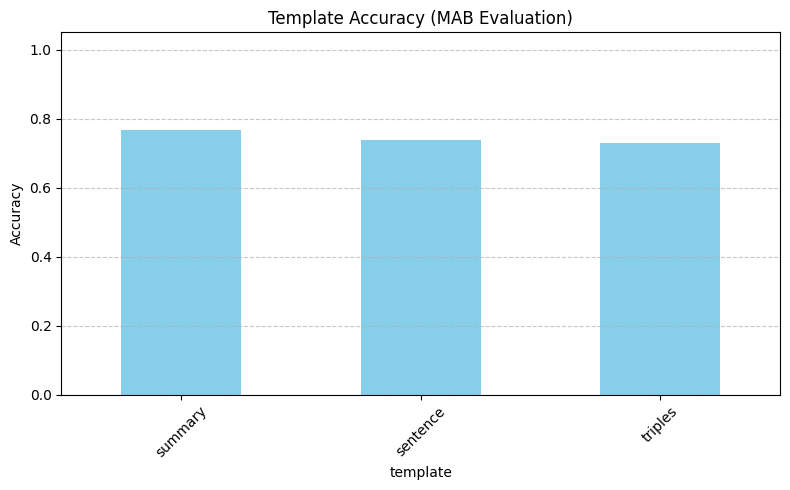

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
accuracy_per_template.plot(kind="bar", color="skyblue")
plt.title("Template Accuracy (MAB Evaluation)")
plt.ylabel("Accuracy")
plt.ylim(0, 1.05)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# TEST

In [ ]:
from tqdm import tqdm

found_count = 0
for sample in tqdm(samples[:100]):
    src = sample["source_entities"][0].lower()
    tgt = sample["target_entity"].lower()

    if src in graph and tgt in graph:
        if nx.has_path(graph, src, tgt):
            found_count += 1
print(f"✅ Có path trong graph cho {found_count}/{len(samples[:100])} câu hỏi")

100%|██████████| 100/100 [00:00<00:00, 6469.30it/s]

✅ Có path trong graph cho 67/100 câu hỏi


In [ ]:
sample = samples[0]
src = sample["source_entities"][0].lower()
tgt = sample["target_entity"].lower()

if nx.has_path(graph, src, tgt):
    path = nx.shortest_path(graph, src, tgt)
    print("📍 Path:", " → ".join(path))
else:
    print(f"⚠️ Không có path giữa {src} và {tgt}")

📍 Path: punishing → hit → success → respect → ignoring → ignore
